# Etude 1: Conway's Game of Life

In [64]:
using DSP

function conway_iter(m)
    nbr = conv(m, [1 1 1; 1 10 1; 1 1 1])
    nbr = nbr[2:end-1,2:end-1] # Crop edges
    return (nbr .== 3) .| (nbr .== 12) .| (nbr .== 13)
end

function hpad(m, n)
    rows, cols = size(m)
    return [zeros(eltype(m), rows, n)  m  zeros(eltype(m), rows, n)]
end
function vpad(m, n)
    rows, cols = size(m)
    return [zeros(eltype(m), n, cols); m;  zeros(eltype(m), n, cols)]
end
function pad(m, n)
    return hpad(vpad(m, n), n)
end

pad (generic function with 1 method)

In [ ]:
using Animations

scene = pad([0 1 0; 1 1 1; 1 0 0], 10)
@gif for i in 1:30
    scene = conway_iter(scene)
    heatmap(scene, yflip=true)
end

# Etude 2: Map Coloring

In [137]:
using LinearAlgebra

function adjacency_matrix(edges; N=nothing)
    N = isnothing(N) ? maximum(edges) : N
    m = Matrix(I, N, N)
    for k in 1:(size(edges)[1])
        a, b = edges[k, :]
        m[a,b] = m[b,a] = 1
    end
    return m
end
    
function color_map(adj, num_colors)
    N = size(adj)[1]
    @assert size(adj) == (N, N)
    scenarios = [fill(0, N)]
    onehot = zeros(Int64, (num_colors, N))
    while length(scenarios) > 0
        cur = pop!(scenarios)
        #@show cur
        max_color = maximum(cur)
        is_empty = cur .== 0
        num_empty = sum(is_empty)
        if num_empty == 0
            return cur
        end
        
        fill!(onehot, 0)
        for (i, c) in enumerate(cur)
            if c != 0
                onehot[c,i] = 1
            end
        end
        allowed = (onehot * adj) .== 0
        total_allowed = vec(sum(allowed, dims=1))
        k = argmin(total_allowed + (2*num_colors) .* (.~is_empty))
        
        for c in min(max_color+1, num_colors):-1:1
            if allowed[c,k]
                v = copy(cur)
                v[k] = c
                push!(scenarios, v)
            end
        end
    end
    return nothing
end
    
    

color_map (generic function with 1 method)

In [138]:
using GeoJSON
using GeoInterface
us_geo = GeoJSON.read(open("us-states.json", "r"));
num_states = length(us_geo.features)
state_names = [properties(f)["name"] for f in us_geo.features];

In [139]:
function flatten(v)
    if v isa AbstractArray
        return [a for vv in v for a in flatten(vv)]
    end
    return [v]
end

flatten (generic function with 1 method)

In [140]:
state_to_point = zeros(num_states, 0)
geo_points = zeros(2, 0)
for (i, state) in enumerate(us_geo.features)
    coords = coordinates(geometry(state))
    points = reshape(flatten(coords), (2, :))
    n = size(points)[2]
    geo_points = [geo_points  points]
    m = zeros(Int64, (num_states, n))
    m[i,:] .= 1
    state_to_point = [state_to_point m]
end

using Distances
dists = pairwise(Euclidean(), geo_points, dims=2)
state_adj = (state_to_point * (dists .< .0001) * transpose(state_to_point)) .> 0
state_colors = color_map(state_adj, 4);

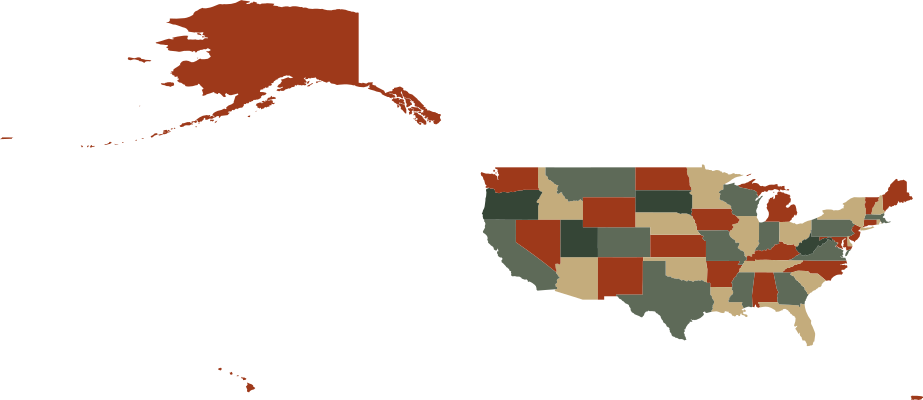

In [141]:
using Luxor, Colors
color_names = ["#9e391a", "#c4ac7c", "#5e6a58", "#354536"]
min_latlon = minimum(geo_points, dims=2)
max_latlon = maximum(geo_points, dims=2)
latlon_span = max_latlon - min_latlon

sz = round.(400 .* latlon_span / minimum(latlon_span))
Drawing(sz[1], sz[2])
for (i, state) in enumerate(us_geo.features)
    setcolor(color_names[state_colors[i]])
    geom = geometry(state)
    function draw_polygon(coord)
        points = hcat(coord[1]...)
            # Note: not currently drawing interior cutouts.
        points .-= min_latlon
        points ./= (max_latlon - min_latlon)
        points[2, :] = 1 .- points[2, :] # y flip.
        points .*= sz
        poly([Luxor.Point(x, y) for (x,y) in eachcol(points)], :fill)
    end
    if geom isa Polygon
        draw_polygon(coordinates(geom))
    elseif geom isa MultiPolygon
        for poly in coordinates(geom)
            draw_polygon(poly)
        end
    end
end

finish()
preview()